# Abstract
This notebook is a natural continuation of [01_TensorflowModeling_CNN.ipynb](./01_TensorflowModeling_CNN.ipynb). I took the 3 most promising models and tried to further refine them to try and get the most out of them. The models in question are models 8,10, and 11 from the previous notebook. 

I leveraged a few more callbacks and allowed for a longer training period on these models to see how they perform.

# Imports

In [67]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.metrics import Precision, Recall

import tensorflow as tf
tf.random.set_seed(
    42
)
import seaborn as sns

tf_chkpt_path = 'tf_Adam_new_checkpoints/'

In [69]:
from src.helperFunctions import display_model_trainTestGraphs

# Training Set

In [70]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=50,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [71]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=100,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [72]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=8,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

## Modeling Callbacks
Tensorflow's neural networks employs callbacks which allow for additional features.\
EarlyStop was utilised in the previous notebook to get a feel for how a model is performing, but is not the best tool to get the most out of your neural network. Your model may start converging after a set of epochs but your early stop might kill the process early. In this notebook all models will run for the same number of epochs and will run to completion.

In [8]:
epochs_to_train = 200 

The disadvantage of having a high learning rate is the model may not converge and bounce around the optimal solution, while the disadvantage of a small learning rate is the model has to train longer to get to a solution. LearningRateScheduler is a callback that allows us to change the learning rate of the algorithm _during_ the training process. Using such a tool can allow us to get the best of both worlds. 
It can be exact learning rates for sets of epochs if desired, however, we are going to use it to decrease by a percentage for every epoch past epoch 10. 

In [10]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_schd_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

We'll also be using a CSVLogger callback to make a dedicated log file that will capture all metrics for every epoch at the end of the epoch for posterity and visualizations

# Model 8 -1 

In [19]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.summary()


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy',
                       Precision(),
                       Recall()
                       ])

csv_logger = CSVLogger('./logs/Model_8_final.log', separator=',', append=False)

results = model.fit(train_generator,
                    steps_per_epoch=150,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[
                        lr_schd_cb,
                        csv_logger,
                    ]
                    )


results.model.save(tf_chkpt_path+'Model_final_8')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 conv2d_41 (Conv2D)          (None, 51, 51, 128)      

150/150 [==============================] - 21s 141ms/step - loss: 0.2147 - accuracy: 0.9344 - precision_5: 0.9412 - recall_5: 0.9283 - val_loss: 0.5055 - val_accuracy: 0.8521 - val_precision_5: 0.8650 - val_recall_5: 0.8435 - lr: 1.4996e-06
Epoch 53/200
150/150 [==============================] - 21s 141ms/step - loss: 0.2032 - accuracy: 0.9388 - precision_5: 0.9442 - recall_5: 0.9320 - val_loss: 0.5018 - val_accuracy: 0.8518 - val_precision_5: 0.8656 - val_recall_5: 0.8439 - lr: 1.3569e-06
Epoch 54/200
150/150 [==============================] - 21s 142ms/step - loss: 0.2152 - accuracy: 0.9349 - precision_5: 0.9400 - recall_5: 0.9281 - val_loss: 0.4975 - val_accuracy: 0.8521 - val_precision_5: 0.8658 - val_recall_5: 0.8421 - lr: 1.2277e-06
Epoch 55/200
150/150 [==============================] - 20s 136ms/step - loss: 0.2119 - accuracy: 0.9357 - precision_5: 0.9417 - recall_5: 0.9297 - val_loss: 0.4992 - val_accuracy: 0.8514 - val_precision_5: 0.8656 - val_recall_5: 0.8422 - lr: 1.1109e-

150/150 [==============================] - 22s 148ms/step - loss: 0.1968 - accuracy: 0.9436 - precision_5: 0.9495 - recall_5: 0.9375 - val_loss: 0.5053 - val_accuracy: 0.8526 - val_precision_5: 0.8657 - val_recall_5: 0.8438 - lr: 2.4916e-09
Epoch 117/200
150/150 [==============================] - 24s 160ms/step - loss: 0.2103 - accuracy: 0.9353 - precision_5: 0.9428 - recall_5: 0.9298 - val_loss: 0.5053 - val_accuracy: 0.8526 - val_precision_5: 0.8657 - val_recall_5: 0.8438 - lr: 2.2545e-09
Epoch 118/200
150/150 [==============================] - 25s 168ms/step - loss: 0.2065 - accuracy: 0.9332 - precision_5: 0.9391 - recall_5: 0.9275 - val_loss: 0.5053 - val_accuracy: 0.8526 - val_precision_5: 0.8657 - val_recall_5: 0.8438 - lr: 2.0399e-09
Epoch 119/200
150/150 [==============================] - 21s 142ms/step - loss: 0.2081 - accuracy: 0.9375 - precision_5: 0.9442 - recall_5: 0.9301 - val_loss: 0.5053 - val_accuracy: 0.8526 - val_precision_5: 0.8657 - val_recall_5: 0.8438 - lr: 1.845

150/150 [==============================] - 21s 140ms/step - loss: 0.2097 - accuracy: 0.9362 - precision_5: 0.9414 - recall_5: 0.9298 - val_loss: 0.5052 - val_accuracy: 0.8526 - val_precision_5: 0.8657 - val_recall_5: 0.8439 - lr: 4.1399e-12
Epoch 181/200
150/150 [==============================] - 21s 137ms/step - loss: 0.2062 - accuracy: 0.9357 - precision_5: 0.9430 - recall_5: 0.9315 - val_loss: 0.5052 - val_accuracy: 0.8526 - val_precision_5: 0.8657 - val_recall_5: 0.8439 - lr: 3.7459e-12
Epoch 182/200
150/150 [==============================] - 21s 139ms/step - loss: 0.2065 - accuracy: 0.9395 - precision_5: 0.9465 - recall_5: 0.9327 - val_loss: 0.5052 - val_accuracy: 0.8526 - val_precision_5: 0.8657 - val_recall_5: 0.8439 - lr: 3.3895e-12
Epoch 183/200
150/150 [==============================] - 21s 137ms/step - loss: 0.1960 - accuracy: 0.9421 - precision_5: 0.9474 - recall_5: 0.9375 - val_loss: 0.5052 - val_accuracy: 0.8526 - val_precision_5: 0.8657 - val_recall_5: 0.8439 - lr: 3.066

INFO:tensorflow:Assets written to: tf_Adam_new_checkpoints/Model_final_8\assets


INFO:tensorflow:Assets written to: tf_Adam_new_checkpoints/Model_final_8\assets


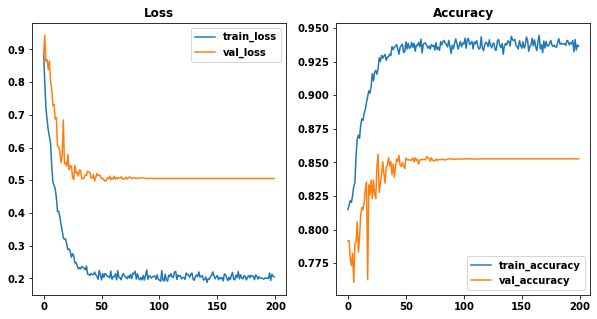

In [20]:
display_model_trainTestGraphs(results)

## Model 10 - 1

Increasing neurons in the fully connected layer

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 73, 73, 64)        9280      
                                                                 
 conv2d_48 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 35, 35, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 33, 33, 128)      

150/150 [==============================] - 18s 119ms/step - loss: 0.1522 - accuracy: 0.9539 - precision_6: 0.9581 - recall_6: 0.9505 - val_loss: 0.4731 - val_accuracy: 0.8637 - val_precision_6: 0.8733 - val_recall_6: 0.8577 - lr: 1.4996e-06
Epoch 53/200
150/150 [==============================] - 19s 129ms/step - loss: 0.1446 - accuracy: 0.9580 - precision_6: 0.9619 - recall_6: 0.9549 - val_loss: 0.4770 - val_accuracy: 0.8611 - val_precision_6: 0.8710 - val_recall_6: 0.8548 - lr: 1.3569e-06
Epoch 54/200
150/150 [==============================] - 19s 127ms/step - loss: 0.1386 - accuracy: 0.9619 - precision_6: 0.9648 - recall_6: 0.9579 - val_loss: 0.4753 - val_accuracy: 0.8672 - val_precision_6: 0.8766 - val_recall_6: 0.8612 - lr: 1.2277e-06
Epoch 55/200
150/150 [==============================] - 18s 117ms/step - loss: 0.1398 - accuracy: 0.9571 - precision_6: 0.9617 - recall_6: 0.9529 - val_loss: 0.4728 - val_accuracy: 0.8656 - val_precision_6: 0.8750 - val_recall_6: 0.8590 - lr: 1.1109e-

150/150 [==============================] - 17s 116ms/step - loss: 0.1630 - accuracy: 0.9524 - precision_6: 0.9574 - recall_6: 0.9495 - val_loss: 0.4777 - val_accuracy: 0.8655 - val_precision_6: 0.8744 - val_recall_6: 0.8602 - lr: 2.4916e-09
Epoch 117/200
150/150 [==============================] - 17s 113ms/step - loss: 0.1390 - accuracy: 0.9600 - precision_6: 0.9635 - recall_6: 0.9567 - val_loss: 0.4777 - val_accuracy: 0.8655 - val_precision_6: 0.8744 - val_recall_6: 0.8602 - lr: 2.2545e-09
Epoch 118/200
150/150 [==============================] - 17s 113ms/step - loss: 0.1421 - accuracy: 0.9614 - precision_6: 0.9653 - recall_6: 0.9583 - val_loss: 0.4777 - val_accuracy: 0.8655 - val_precision_6: 0.8744 - val_recall_6: 0.8602 - lr: 2.0399e-09
Epoch 119/200
150/150 [==============================] - 17s 115ms/step - loss: 0.1431 - accuracy: 0.9577 - precision_6: 0.9617 - recall_6: 0.9547 - val_loss: 0.4777 - val_accuracy: 0.8655 - val_precision_6: 0.8744 - val_recall_6: 0.8602 - lr: 1.845

150/150 [==============================] - 17s 115ms/step - loss: 0.1419 - accuracy: 0.9598 - precision_6: 0.9635 - recall_6: 0.9565 - val_loss: 0.4777 - val_accuracy: 0.8655 - val_precision_6: 0.8744 - val_recall_6: 0.8603 - lr: 4.1399e-12
Epoch 181/200
150/150 [==============================] - 18s 119ms/step - loss: 0.1420 - accuracy: 0.9597 - precision_6: 0.9633 - recall_6: 0.9559 - val_loss: 0.4777 - val_accuracy: 0.8655 - val_precision_6: 0.8744 - val_recall_6: 0.8603 - lr: 3.7459e-12
Epoch 182/200
150/150 [==============================] - 17s 113ms/step - loss: 0.1415 - accuracy: 0.9577 - precision_6: 0.9630 - recall_6: 0.9535 - val_loss: 0.4777 - val_accuracy: 0.8655 - val_precision_6: 0.8744 - val_recall_6: 0.8603 - lr: 3.3895e-12
Epoch 183/200
150/150 [==============================] - 19s 125ms/step - loss: 0.1418 - accuracy: 0.9591 - precision_6: 0.9636 - recall_6: 0.9561 - val_loss: 0.4777 - val_accuracy: 0.8655 - val_precision_6: 0.8744 - val_recall_6: 0.8603 - lr: 3.066

INFO:tensorflow:Assets written to: tf_Adam_new_checkpoints/Model_10_final\assets


INFO:tensorflow:Assets written to: tf_Adam_new_checkpoints/Model_10_final\assets


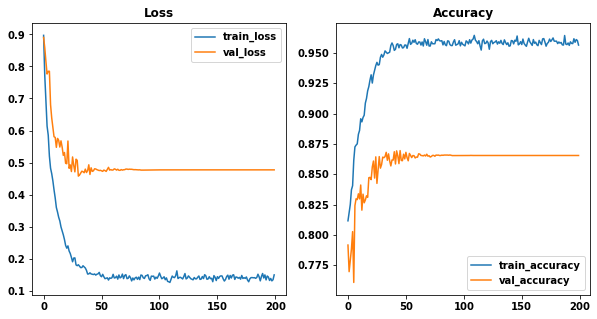

In [21]:
model = models.Sequential()

model.add(layers.Conv2D(16, 3, activation='relu',
                        input_shape=(227, 227, 1)
                        ))
model.add(layers.MaxPooling2D(3, 3))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))


model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))


model.add(layers.Dense(8, activation='softmax'))


model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy',
                       Precision(),
                       Recall()
                       ])


csv_logger = CSVLogger('./logs/Model_10_final.log', separator=',', append=False)

results = model.fit(train_generator,
                    steps_per_epoch=150,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[
                        lr_schd_cb,
                        csv_logger,
#                         early_stop
                    ]
                    )


results.model.save(tf_chkpt_path+'Model_10_final')

display_model_trainTestGraphs(results)

## Model 11-1

Epoch 1/200
150/150 [==============================] - 11s 72ms/step - loss: 0.9263 - accuracy: 0.8057 - precision_11: 0.8156 - recall_11: 0.7456 - val_loss: 0.8889 - val_accuracy: 0.7961 - val_precision_11: 0.7951 - val_recall_11: 0.7788 - lr: 1.0000e-04
Epoch 2/200
150/150 [==============================] - 11s 71ms/step - loss: 0.8011 - accuracy: 0.8140 - precision_11: 0.8175 - recall_11: 0.8085 - val_loss: 0.8467 - val_accuracy: 0.7929 - val_precision_11: 0.7953 - val_recall_11: 0.7697 - lr: 1.0000e-04
Epoch 3/200
150/150 [==============================] - 11s 72ms/step - loss: 0.6999 - accuracy: 0.8268 - precision_11: 0.8425 - recall_11: 0.8068 - val_loss: 0.8375 - val_accuracy: 0.7861 - val_precision_11: 0.8049 - val_recall_11: 0.7385 - lr: 1.0000e-04
Epoch 4/200
150/150 [==============================] - 11s 71ms/step - loss: 0.6940 - accuracy: 0.8207 - precision_11: 0.8573 - recall_11: 0.7875 - val_loss: 0.8564 - val_accuracy: 0.7527 - val_precision_11: 0.8053 - val_recall_11: 

Epoch 33/200
150/150 [==============================] - 11s 73ms/step - loss: 0.2732 - accuracy: 0.9179 - precision_11: 0.9302 - recall_11: 0.9049 - val_loss: 0.5457 - val_accuracy: 0.8280 - val_precision_11: 0.8601 - val_recall_11: 0.7979 - lr: 1.0026e-05
Epoch 34/200
150/150 [==============================] - 11s 73ms/step - loss: 0.2700 - accuracy: 0.9146 - precision_11: 0.9264 - recall_11: 0.9027 - val_loss: 0.5388 - val_accuracy: 0.8340 - val_precision_11: 0.8554 - val_recall_11: 0.8179 - lr: 9.0718e-06
Epoch 35/200
150/150 [==============================] - 11s 72ms/step - loss: 0.2786 - accuracy: 0.9128 - precision_11: 0.9264 - recall_11: 0.8996 - val_loss: 0.5421 - val_accuracy: 0.8276 - val_precision_11: 0.8556 - val_recall_11: 0.8069 - lr: 8.2085e-06
Epoch 36/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2984 - accuracy: 0.9136 - precision_11: 0.9254 - recall_11: 0.9009 - val_loss: 0.5255 - val_accuracy: 0.8315 - val_precision_11: 0.8566 - val_recall_

Epoch 65/200
150/150 [==============================] - 11s 72ms/step - loss: 0.2410 - accuracy: 0.9245 - precision_11: 0.9348 - recall_11: 0.9160 - val_loss: 0.5295 - val_accuracy: 0.8320 - val_precision_11: 0.8593 - val_recall_11: 0.8167 - lr: 4.0868e-07
Epoch 66/200
150/150 [==============================] - 11s 72ms/step - loss: 0.2501 - accuracy: 0.9235 - precision_11: 0.9348 - recall_11: 0.9112 - val_loss: 0.5390 - val_accuracy: 0.8275 - val_precision_11: 0.8574 - val_recall_11: 0.8115 - lr: 3.6979e-07
Epoch 67/200
150/150 [==============================] - 11s 72ms/step - loss: 0.2666 - accuracy: 0.9153 - precision_11: 0.9289 - recall_11: 0.9055 - val_loss: 0.5350 - val_accuracy: 0.8279 - val_precision_11: 0.8532 - val_recall_11: 0.8099 - lr: 3.3460e-07
Epoch 68/200
150/150 [==============================] - 11s 72ms/step - loss: 0.2574 - accuracy: 0.9243 - precision_11: 0.9333 - recall_11: 0.9121 - val_loss: 0.5370 - val_accuracy: 0.8333 - val_precision_11: 0.8564 - val_recall_

Epoch 97/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2620 - accuracy: 0.9221 - precision_11: 0.9295 - recall_11: 0.9127 - val_loss: 0.5341 - val_accuracy: 0.8357 - val_precision_11: 0.8601 - val_recall_11: 0.8173 - lr: 1.6659e-08
Epoch 98/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2589 - accuracy: 0.9216 - precision_11: 0.9322 - recall_11: 0.9099 - val_loss: 0.5406 - val_accuracy: 0.8300 - val_precision_11: 0.8560 - val_recall_11: 0.8124 - lr: 1.5073e-08
Epoch 99/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2582 - accuracy: 0.9221 - precision_11: 0.9329 - recall_11: 0.9127 - val_loss: 0.5333 - val_accuracy: 0.8323 - val_precision_11: 0.8589 - val_recall_11: 0.8145 - lr: 1.3639e-08
Epoch 100/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2658 - accuracy: 0.9185 - precision_11: 0.9300 - recall_11: 0.9075 - val_loss: 0.5176 - val_accuracy: 0.8381 - val_precision_11: 0.8637 - val_recall

Epoch 129/200
150/150 [==============================] - 11s 72ms/step - loss: 0.2596 - accuracy: 0.9216 - precision_11: 0.9336 - recall_11: 0.9117 - val_loss: 0.5285 - val_accuracy: 0.8351 - val_precision_11: 0.8593 - val_recall_11: 0.8177 - lr: 6.7904e-10
Epoch 130/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2664 - accuracy: 0.9215 - precision_11: 0.9308 - recall_11: 0.9093 - val_loss: 0.5135 - val_accuracy: 0.8375 - val_precision_11: 0.8615 - val_recall_11: 0.8191 - lr: 6.1442e-10
Epoch 131/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2652 - accuracy: 0.9199 - precision_11: 0.9310 - recall_11: 0.9080 - val_loss: 0.5365 - val_accuracy: 0.8340 - val_precision_11: 0.8597 - val_recall_11: 0.8163 - lr: 5.5595e-10
Epoch 132/200
150/150 [==============================] - 11s 70ms/step - loss: 0.2574 - accuracy: 0.9224 - precision_11: 0.9319 - recall_11: 0.9141 - val_loss: 0.5258 - val_accuracy: 0.8347 - val_precision_11: 0.8616 - val_rec

Epoch 161/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2419 - accuracy: 0.9248 - precision_11: 0.9368 - recall_11: 0.9145 - val_loss: 0.5329 - val_accuracy: 0.8329 - val_precision_11: 0.8594 - val_recall_11: 0.8149 - lr: 2.7679e-11
Epoch 162/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2571 - accuracy: 0.9204 - precision_11: 0.9316 - recall_11: 0.9081 - val_loss: 0.5398 - val_accuracy: 0.8309 - val_precision_11: 0.8564 - val_recall_11: 0.8121 - lr: 2.5045e-11
Epoch 163/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2463 - accuracy: 0.9241 - precision_11: 0.9350 - recall_11: 0.9124 - val_loss: 0.5181 - val_accuracy: 0.8359 - val_precision_11: 0.8614 - val_recall_11: 0.8173 - lr: 2.2662e-11
Epoch 164/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2592 - accuracy: 0.9185 - precision_11: 0.9301 - recall_11: 0.9060 - val_loss: 0.5308 - val_accuracy: 0.8315 - val_precision_11: 0.8583 - val_rec

Epoch 193/200
150/150 [==============================] - 11s 70ms/step - loss: 0.2697 - accuracy: 0.9164 - precision_11: 0.9279 - recall_11: 0.9067 - val_loss: 0.5230 - val_accuracy: 0.8361 - val_precision_11: 0.8633 - val_recall_11: 0.8192 - lr: 1.1283e-12
Epoch 194/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2517 - accuracy: 0.9260 - precision_11: 0.9356 - recall_11: 0.9160 - val_loss: 0.5372 - val_accuracy: 0.8329 - val_precision_11: 0.8597 - val_recall_11: 0.8137 - lr: 1.0209e-12
Epoch 195/200
150/150 [==============================] - 11s 71ms/step - loss: 0.2596 - accuracy: 0.9204 - precision_11: 0.9327 - recall_11: 0.9100 - val_loss: 0.5215 - val_accuracy: 0.8368 - val_precision_11: 0.8614 - val_recall_11: 0.8188 - lr: 9.2374e-13
Epoch 196/200
150/150 [==============================] - 11s 70ms/step - loss: 0.2608 - accuracy: 0.9191 - precision_11: 0.9309 - recall_11: 0.9095 - val_loss: 0.5398 - val_accuracy: 0.8327 - val_precision_11: 0.8586 - val_rec

INFO:tensorflow:Assets written to: tf_Adam_new_checkpoints/Model_11_final\assets


INFO:tensorflow:Assets written to: tf_Adam_new_checkpoints/Model_11_final\assets


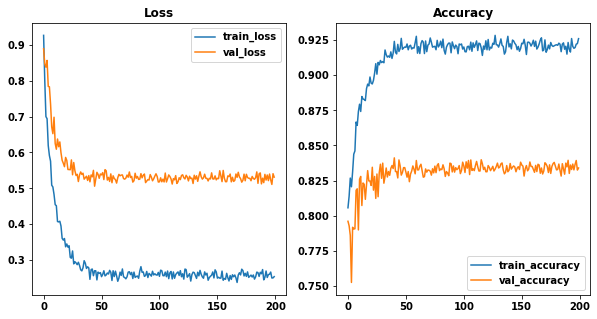

In [27]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(3,3))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))


model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


csv_logger = CSVLogger('./logs/Model_11_final.log', separator=',', append=False)

results = model.fit(train_generator,
                    steps_per_epoch=150,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=75,
                    verbose=1,
                    callbacks=[
                        lr_schd_cb,
                        csv_logger,
                    ]
                    )


results.model.save(tf_chkpt_path+'Model_11_final')

display_model_trainTestGraphs(results)

# Visualizations

In [35]:
model8_df  = pd.read_csv('./logs/Model_8_final.log',index_col='epoch')
model10_df = pd.read_csv('./logs/Model_10_final.log',index_col='epoch')
model11_df = pd.read_csv('./logs/Model_11_final.log',index_col='epoch')

In [36]:
model8_df

,accuracy,loss,lr,precision_5,recall_5,val_accuracy,val_loss,val_precision_5,val_recall_5
epoch,,,,,,,,,
0,0.814800,0.888982,1.000000e-04,0.822717,0.762933,0.791605,0.880305,0.791605,0.791605
1,0.818400,0.799258,1.000000e-04,0.818412,0.817867,0.791605,0.942750,0.791605,0.791605
2,0.821467,0.723108,1.000000e-04,0.844444,0.800533,0.777989,0.863570,0.791857,0.758730
3,0.820267,0.685383,1.000000e-04,0.854416,0.781733,0.773192,0.868773,0.806669,0.718518
4,0.825200,0.653501,1.000000e-04,0.866971,0.784667,0.782222,0.837859,0.805663,0.746667
...,...,...,...,...,...,...,...,...,...
195,0.932400,0.216690,8.358308e-13,0.939652,0.928000,0.852628,0.505248,0.865682,0.843880
196,0.941600,0.193727,7.562909e-13,0.947766,0.936267,0.852628,0.505248,0.865682,0.843880
197,0.933733,0.212705,6.843203e-13,0.939194,0.928800,0.852628,0.505248,0.865682,0.843880


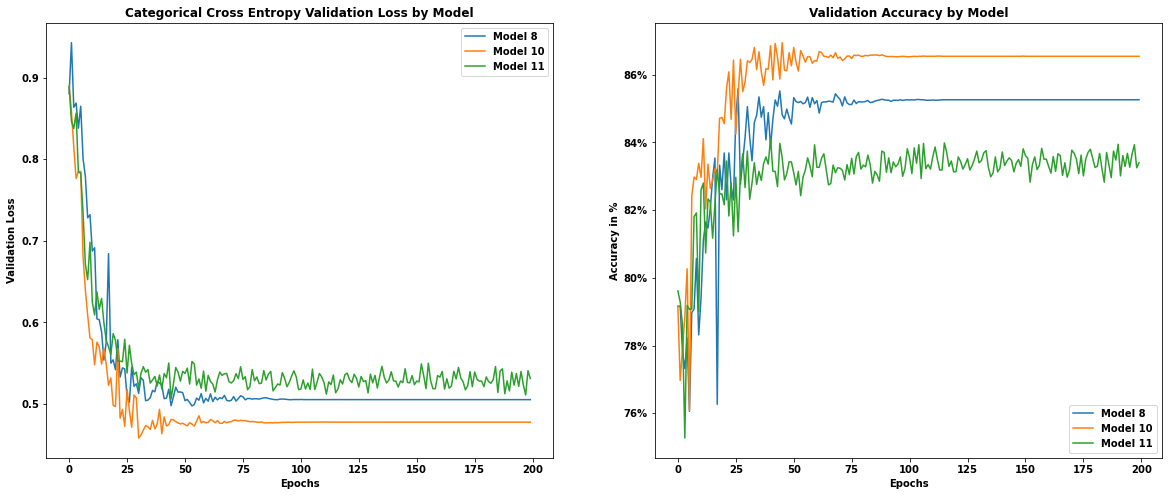

In [65]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,8))
ax1.plot(model8_df.index,model8_df.val_loss)
ax1.plot(model10_df.index,model10_df.val_loss)
ax1.plot(model11_df.index,model11_df.val_loss)
ax1.set_title('Categorical Cross Entropy Validation Loss by Model')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss')
ax1.legend(['Model 8', 'Model 10', 'Model 11'])

ax2.plot(model8_df.index,model8_df.val_accuracy)
ax2.plot(model10_df.index,model10_df.val_accuracy)
ax2.plot(model11_df.index,model11_df.val_accuracy)
ax2.set_title('Validation Accuracy by Model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy in %')
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(f'{round(x*100)}%'))
)
ax2.legend(['Model 8', 'Model 10', 'Model 11'])

plt.savefig('./savedFigs/Model_8_10_11_Performance.jpg', dpi='figure', 
          bbox_inches='tight', pad_inches=0.1,
          facecolor='auto', edgecolor='auto',
         )

plt.show()

In [76]:
m = models.load_model('tf_Adam_new_checkpoints/Model_10_final/')

In [77]:
m.evaluate(val_generator)

142/142 [==============================] - 10s 63ms/step - loss: 0.4777 - accuracy: 0.8655 - precision_6: 0.8744 - recall_6: 0.8603


[0.4776621460914612, 0.865467369556427, 0.874444305896759, 0.8603174686431885]

# Conclusions

It is clear looking at the charts that model 10 is our best performing model of the bunch with a validation accuracy of 86.55% and validation loss score of 0.4777
